# PHYS3116

## Stellar Model

## From Part 1:

In [1]:
# Import the libraries we need.

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

%matplotlib inline

In [2]:
# Define physical constants.
# All values come from Appendix A of Carroll & Ostlie

a = 7.565767E-16               # Radiation constant, J mol^-3 K^-4
G = 6.67428E-11                # Gravitational constant, m^3 kg^-1 s^-2
c = 2.99792458E8               # Speed of light, m s^-1
boltzmann = 1.3806504E-23      # Boltzmann's constant, J K^-1
H_mass = 1.673532499E-27       # Mass of a hydrogen atom, kg
sigma = 5.670400E-8            # Stefan-Boltzmann constant, W m^-2 K^-4
R = boltzmann/H_mass           # Ideal gas constant, J K^-1 kg^-1

# Solar parameters:

Msun = 1.989E30                # Mass of Sun
Rsun = 6.95508E8               # Radius of Sun
Lsun = 3.839E26                # Luminosity of Sun

# Stellar parameters:

Mtot = 1.2*Msun                # 20% more massive than the Sun 
mfraction = 1e-8               # Fractional mass of core 
X = 0.7                        # Mass fraction of hydrogen
Y = 0.2                        # Mass fraction of helium
log_pc_i = 17.1                # Initial estimate for pressure at the centre of the star (slightly higher than Sun)
log_tc_i = 7.4                 # Initial estimate for temperature at the centre of the star (slightly higher than Sun)
log_rs_i = 8.85                # Initial estimate for full radius of the star (slightly higher than Sun)
log_ls_i = 26.6                # Initial estimate for full luminosity of the star (slightly higher than Sun)

In [3]:
# Define functions from Part 1:

def mean_molecular_weight(X,Y):
    """
    Calculates the mean molecular weight.
    
    Parameters
    ----------
    X: float
        Mass fraction of hydrogen
    Y: float
        Mass fraction of helium
        
    Returns
    -------
    mu: float
        Mean molecular weight
    """
    
    Z = (1 - X - Y)
    mu = 1/((2*X)+(0.75*Y)+(0.5*Z))
    
    return mu

def density(P,T,mu):
    """
    Calculates the density.
    
    Parameters
    ----------
    P: float
        Total pressure
    T: float
        Temperature
    mu: float
        Mean molecular weight
        
    Returns
    -------
    rho: float
        Density
    """
    
    rho = (mu/(R*T))*(P-(a*T**4)/3)
    
    return rho

def pressure_to_density_beta(X, Y, logT, logP):
    """
    Accepts values for X, Y, log(T), and log(P), and returns values for rho and beta.
    """
    
    mu = mean_molecular_weight(X,Y)
    rho = density(10**logP, 10**logT, mu)
    gas_pressure = (R/mu)*rho*(10**logT)
    beta = gas_pressure/(10**logP)
    
    return rho, beta

def opacity(logT, logrho, X, Y):
    T = 10**logT
    rho = 10**(logrho - 3)        # -3 converts input quantities from SI to cgs units to support coefficients below
    
    #Kramer's opacity law: kappa is proportional to rho and T^-3.5
    k_bf = (4.34e25*(1-X-Y)*(1+X)*rho*np.power(T,-3.5))/(2.82*np.power(rho*(1+X),0.2))  #bound-free absorption
    k_ff = 3.68e22*(X+Y)*(1+X)*rho*np.power(T,-3.5)                                     #free-free absorption
    k_es = 0.2*(1+X)                                                                    #electron scattering
    
    return np.log10(k_bf + k_ff + k_es) - 1                                             # -1 to convert to SI units

def energy_generation(logrho,logT,X,Y):
    t6 = (10**logT)/(1E6)
    rho = 10**logrho
    Xcno = 0.7263*(1-X-Y)
    
    eps_pp = 0.241*rho*np.power(X,2)*np.power(t6,-2/3)*np.exp(-33.8/np.power(t6,1/3))
    eps_CNO = 8.67E20*rho*X*Xcno*np.power(t6,-2/3)*np.exp(-152.28/np.power(t6,1/3))

    eps = eps_pp + eps_CNO
    
    return eps

## From Part 2:

In [4]:
# Define functions from Part 2:

def centre(m, log_pc_i, log_tc_i, X, Y):
    m = mfraction*Mtot
    p_c_i = 10**log_pc_i
    t_c_i = 10**log_tc_i
    
    ## Incorporate previously defined functions ##
    rho_c, beta_c = pressure_to_density_beta(X=X, Y=Y, logT=log_tc_i, logP=log_pc_i)
    epsilon_c = energy_generation(logrho=np.log10(rho_c), logT=log_tc_i, X=X, Y=Y)
    log_kappa_c = opacity(logT=log_tc_i, logrho=np.log10(rho_c), X=X, Y=Y)
    kappa_c = 10**log_kappa_c
    
    ## Calculate radius, luminosity, and pressure ##
    r_c = np.power(0.75/(np.pi*rho_c), 1/3)*np.power(m, 1/3)
    l_c = epsilon_c*m
    p_c = p_c_i - (3*G/(8*np.pi))*np.power((4*np.pi*rho_c)/3, 4/3)*np.power(m, 2/3)
    
    ## Define temperature gradients ##
    grad_ad = (((1-beta_c)*(4+beta_c))/(beta_c**2) + 1)/(((4*(1-beta_c)*(4+beta_c))/(beta_c**2))+2.5)
    grad_rad = (3*kappa_c*l_c*p_c)/(16*np.pi*G*a*c*m*np.power(t_c_i, 4))
    
    ## Calculate temperature for convective/radiative core ##
    if grad_rad < grad_ad:
        t_4 = np.power(t_c_i, 4) - (0.5/(a*c))*np.power(0.75/np.pi, 2/3)*kappa_c*epsilon_c*np.power(rho_c, 4/3)*np.power(m, 2/3)
        t_c = np.power(t_4, 1/4)
        #print('Core is radiative!')
    else:
        ln_t = np.log(t_c_i) - np.power(np.pi/6, 1/3)*G*grad_ad*np.power(rho_c, 4/3)*np.power(m, 2/3)/p_c_i
        t_c = np.exp(ln_t)
        #print('Core is convective!')
    
    return r_c, l_c, p_c, t_c

def surface(m, log_rs_i, log_ls_i, init_ps):
    m = Mtot
    r_s = 10**log_rs_i
    l_s = 10**log_ls_i
    t_s = np.power(l_s/(4*np.pi*np.power(r_s, 2)*sigma), 1/4)
    
    trial_ps = init_ps
    candidate_ps = 0
    diff = 0
  
    while (np.abs((trial_ps - candidate_ps)/trial_ps)) > 0.05:
        logt_s = np.log10(t_s)
        log_trial_ps = np.log10(trial_ps)
        trial_ps = trial_ps + diff
        rho_s, beta_s = pressure_to_density_beta(0.7,0.2,logt_s,log_trial_ps)
        logrho_s = np.log10(rho_s)
        logkappa_s = opacity(logt_s, logrho_s, 0.7, 0.2)
        kappa_s = 10**logkappa_s
        candidate_ps = ((G*m)/(r_s**2))*(2/(3*kappa_s))
        diff = (candidate_ps - trial_ps)*0.1

    while np.abs((trial_ps - candidate_ps)/trial_ps) > 0.05:
        diff = trial_ps - candidate_ps
        trial_ps = trial_ps - 0.1*diff
        rho_s, beta_s = pressure_to_density_beta(X=X, Y=Y, logT=np.log10(t_s), logP=np.log10(trial_ps))
        log_kappa_s = opacity(logT=np.log10(t_s), logrho=np.log10(rho_s), X=X, Y=Y)
        kappa_s = 10**log_kappa_s
        candidate_ps = (2*G*m)/(3*kappa_s*(r_s**2))
        
    return r_s, l_s, candidate_ps, t_s
    
def partial_derivatives(rlpt, m):
    # Unpack rlpt
    r = rlpt[0]
    l = rlpt[1]
    p = rlpt[2]
    t = rlpt[3]
    
    # Convert to log10 as this is used in our previous functions
    logl = np.log10(l)
    logp = np.log10(p)
    logt = np.log10(t)
    
    # Use previous functions to calculate rho, beta, epsilon, and kappa
    rho, beta = pressure_to_density_beta(X=X, Y=Y, logT=logt, logP=logp)
    logrho = np.log10(rho)
    epsilon = energy_generation(logrho=logrho, logT=logt, X=X, Y=Y)
    log_kappa = opacity(logT=logt, logrho=logrho, X=X, Y=Y)
    kappa = 10**log_kappa
    
    # Calculate grad as the lesser of grad_rad and grad_ad
    grad_ad = (((1-beta)*(4+beta))/(beta**2) + 1)/(((4*(1-beta)*(4+beta))/(beta**2))+2.5)
    grad_rad = (3*kappa*l*p)/(16*np.pi*G*a*c*m*np.power(t, 4))
    grad = min(grad_rad, grad_ad)
    
    # Find the derivatives in our equations of stellar structure
    drdm = 1/(4*np.pi*np.power(r, 2)*rho)
    dldm = epsilon
    dpdm = -(G*m)/(4*np.pi*np.power(r, 4))
    dtdm = -(G*m*t*grad)/(4*np.pi*p*np.power(r, 4))

    return [drdm, dldm, dpdm, dtdm]

## From Part 3:

In [5]:
# Define functions from Part 3:

def model(rlpt, do_plot):
    
    log_rs, log_ls, log_pc, log_tc = np.log10(rlpt)
    
    meeting_point = 0.67
    
    # Choose mass steps for the integration from the inner point,
    # integrating outwards to a mass of (Mtot*meeting_point)
    
    mgrid_c = Mtot*np.linspace(mfraction, meeting_point, 10000)
    mgrid_c = np.append(mgrid_c, mgrid_c[-1] + np.diff(mgrid_c)[0])
    mass_step_out = mgrid_c
    
    # Set up the initial values at the centre
    
    rlpt_c = centre(m=mfraction,log_pc_i=log_pc,log_tc_i=log_tc,X=X,Y=Y)
    
    # Integrate from the centre outward
    
    solve_outwards = odeint(partial_derivatives, rlpt_c, mgrid_c)
    
    # Choose mass steps for the integration from the surface,
    # integrating inwards to a mass of (Mtot*meeting_point).
    # We take tiny steps when we are close to the surface,
    # since change is rapid there.
    
    mgrid_s1 = np.linspace(Mtot, Mtot*(2.9999/3), 10000)
    mgrid_s2 = np.linspace(Mtot*(2.9999/3), meeting_point*Mtot, 10000)
    mgrid_s2 = np.append(mgrid_s2, mgrid_s2[-1] + np.diff(mgrid_s2)[0])
    mgrid_s = np.concatenate([mgrid_s1[:-1], mgrid_s2], axis=0)
    mass_step_in = mgrid_s
    
    # Set up the initial values at the surface
    
    rlpt_s = surface(m=Mtot, log_rs_i=log_rs, log_ls_i=log_ls, init_ps=1e3)
    
    # Integrate from the surface inwards
    
    solve_inwards = odeint(partial_derivatives, rlpt_s, mgrid_s)
    
    # Calculate the offsets at the meeting point
    
    delta_r = solve_outwards[-2][0] - solve_inwards[-2][0]    # [-2] is meeting point, [0] is radius
    delta_l = solve_outwards[-2][1] - solve_inwards[-2][1]    # '' [1] is luminosity
    delta_p = solve_outwards[-2][2] - solve_inwards[-2][2]    # '' [2] is pressure
    delta_t = solve_outwards[-2][3] - solve_inwards[-2][3]    # '' [3] is temperature
    
    step_r = max([np.abs(solve_outwards[-1][0] - solve_outwards[-2][0]),np.abs(solve_inwards[-1][0]-solve_inwards[-2][0])])
    step_l = max([np.abs(solve_outwards[-1][1] - solve_outwards[-2][1]),np.abs(solve_inwards[-1][1]-solve_inwards[-2][1])])
    step_p = max([np.abs(solve_outwards[-1][2] - solve_outwards[-2][2]),np.abs(solve_inwards[-1][2]-solve_inwards[-2][2])])
    step_t = max([np.abs(solve_outwards[-1][3] - solve_outwards[-2][3]),np.abs(solve_inwards[-1][3]-solve_inwards[-2][3])])
    
    # Calculate values for density and energy generation so we can plot these as well
    
    pres_c = np.log10(solve_outwards[:,2])
    temp_c = np.log10(solve_outwards[:,3])
    pres_s = np.log10(solve_inwards[:,2])
    temp_s = np.log10(solve_inwards[:,3])

    rho_cen, beta_cen = pressure_to_density_beta(X=X, Y=Y, logT=temp_c, logP=pres_c)
    rho_sur, beta_sur = pressure_to_density_beta(X=X, Y=Y, logT=temp_s, logP=pres_s)
    e_cen = energy_generation(logrho=np.log10(rho_cen), logT=temp_c, X=X, Y=Y)
    e_sur = energy_generation(logrho=np.log10(rho_sur), logT=temp_s, X=X, Y=Y)
    
    
    # If requested, make some plots
    
    if do_plot:
        
        # Plots showing step distribution for each integration
        
        fig = plt.figure(figsize=(15,7.5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.scatter(np.arange(len(mgrid_c)), mgrid_c)
        ax1.axvline(x=10000, ls='--', c='k')

        ax2.scatter(np.arange(len(mgrid_s)), mgrid_s)
        ax2.axvline(x=0, ls='--')
        ax2.axvline(x=10000, ls='--')
        ax2.axvline(x=20000, ls='--', c='k')
        ax2.text(x= 1500, y = 1.9e30, s='Outermost Surface')
        
        ax1.set_xlabel('Outward Steps')
        ax1.set_ylabel('Mass of Star')
        ax2.set_xlabel('Inward Steps')
        ax2.set_ylabel('Mass of Star')
        plt.show()
        
        # Plots showing R, L, P, T against M
        
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(321)
        ax2 = fig.add_subplot(322)
        ax3 = fig.add_subplot(323)
        ax4 = fig.add_subplot(324)
        ax5 = fig.add_subplot(325)
        ax6 = fig.add_subplot(326)
        
        ax1.plot(mass_step_out/Msun, solve_outwards[:,0]/Rsun)
        ax1.plot(mass_step_in/Msun, solve_inwards[:,0]/Rsun)
        ax1.set_xlabel('Mass [solar masses]')
        ax1.set_ylabel('Radius [solar radii]')
        
        ax2.plot(mass_step_out/Msun, solve_outwards[:,1]/Lsun)
        ax2.plot(mass_step_in/Msun, solve_inwards[:,1]/Lsun)
        ax2.set_xlabel('Mass [solar masses]')
        ax2.set_ylabel('Luminosity [solar luminosities]')
        
        ax3.plot(mass_step_out/Msun, solve_outwards[:,2])
        ax3.plot(mass_step_in/Msun, solve_inwards[:,2])
        ax3.set_xlabel('Mass [solar masses]')
        ax3.set_ylabel('Pressure')
        
        ax4.plot(mass_step_out/Msun, solve_outwards[:,3])
        ax4.plot(mass_step_in/Msun, solve_inwards[:,3])
        ax4.set_xlabel('Mass [solar masses]')
        ax4.set_ylabel('Temperature')
        
        ax5.plot(mass_step_out/Msun, rho_cen)
        ax5.plot(mass_step_in/Msun, rho_sur)
        ax5.set_xlabel('Mass [solar masses]')
        ax5.set_ylabel('Density')
        
        ax6.plot(mass_step_out/Msun, e_cen)
        ax6.plot(mass_step_in/Msun, e_sur)
        ax6.set_xlabel('Mass [solar masses]')
        ax6.set_ylabel('Energy generation')
        
        plt.show()
        
    return (np.array([delta_r, delta_l, delta_p, delta_t]), np.array([step_r, step_l, step_p, step_t]))  

## Part 4:

The final step in making our stellar model will call upon the functions we have already written to set up the initial values and carry out the integrations from the centre and surface of the star to the meeting point at $\frac{2}{3}M_{tot}$. We will add a new section that uses the results of these integrations and the calculated offsets between them to adjust the initial conditions. The program will iterate through this process until the integrations meet to within an appropriate tolerance.

Adjusting the initial conditions is done by calculating partial derivatives to measure the sensitivity of the mismatches to the initial conditions. We do this by changing each of the four initial estimates ($R_s$, $L_s$, $P_c$, and $T_c$) by a small amount ($1\%$ is a good change), one at a time. We then run the integrations to the meeting point and see how much the mismatches change. For example, by re-running the integration with ($1.01 \times R_s$, $L_s$, $P_c$, and $T_c$) as the inputs, we can calulate $\frac{\partial\Delta R}{\partial R_s}$ as $\frac{\Delta R(\text{new integration}) - \Delta R(\text{original integration})}{0.01\times R_s}$. Our other partial derivatives $\frac{\partial\Delta L}{\partial R_s}$, $\frac{\partial\Delta P}{\partial R_s}$, and $\frac{\partial\Delta T}{\partial R_s}$ are calculated similarly.

We will write code to run four new integrations, varying each of the inputs in turn by $1\%$, and create the following matrix of partial derivatives:

\begin{equation*}\begin{bmatrix}\frac{\partial \Delta R}{\partial R_{s}}&\frac{\partial \Delta R}{\partial L_{s}} & \frac{\partial \Delta R}{\partial P_{c}} & \frac{\partial \Delta R}{\partial T_{c}}\\
\frac{\partial \Delta L}{\partial R_{s}}&\frac{\partial \Delta L}{\partial L_{s}}&\frac{\partial \Delta L}{\partial P_{c}} & \frac{\partial \Delta L}{\partial T_{c}}\\
\frac{\partial \Delta P}{\partial R_{s}}&\frac{\partial \Delta P}{\partial L_{s}} & \frac{\partial \Delta P}{\partial P_{c}} & \frac{\partial \Delta P}{\partial T_{c}}\\
\frac{\partial \Delta T}{\partial R_{s}}&\frac{\partial \Delta T}{\partial L_{s}}&\frac{\partial \Delta T}{\partial P_{c}}&\frac{\partial \Delta T}{\partial T_{c}}
\end{bmatrix}\end{equation*}

We will then solve the following equation, which is essentially (partial derivatives $\times$ adjustments $ = -$ mismatches), to find the adjustments vector.

\begin{equation*}
\begin{bmatrix}
\frac{\partial \Delta R}{\partial R_{s}}&\frac{\partial \Delta R}{\partial L_{s}} & \frac{\partial \Delta R}{\partial P_{c}} & \frac{\partial \Delta R}{\partial T_{c}}\\
\frac{\partial \Delta L}{\partial R_{s}}&\frac{\partial \Delta L}{\partial L_{s}} & \frac{\partial \Delta L}{\partial P_{c}} & \frac{\partial \Delta L}{\partial T_{c}}\\
\frac{\partial \Delta P}{\partial R_{s}}&\frac{\partial \Delta P}{\partial L_{s}} & \frac{\partial \Delta P}{\partial P_{c}} & \frac{\partial \Delta P}{\partial T_{c}}\\
\frac{\partial \Delta T}{\partial R_{s}}&\frac{\partial \Delta T}{\partial L_{s}} & \frac{\partial \Delta T}{\partial P_{c}}&\frac{\partial \Delta T}{\partial T_{c}}
\end{bmatrix}\begin{bmatrix}A(R_{s})\\A(L_{s})\\A(P_{c})\\A(T_{c})\end{bmatrix}
=-\begin{bmatrix}\Delta R \\ \Delta L \\ \Delta P \\ \Delta T\end{bmatrix}\end{equation*}

We can do this by calculating the inverse of the partial derivatives matrix and multiplying it by the mismatch vector:

\begin{equation*}
\begin{bmatrix}
\frac{\partial \Delta R}{\partial R_{s}}&\frac{\partial \Delta R}{\partial L_{s}} & \frac{\partial \Delta R}{\partial P_{c}} & \frac{\partial \Delta R}{\partial T_{c}}\\
\frac{\partial \Delta L}{\partial R_{s}}&\frac{\partial \Delta L}{\partial L_{s}}&\frac{\partial \Delta L}{\partial P_{c}} & \frac{\partial \Delta L}{\partial T_{c}}\\
\frac{\partial \Delta P}{\partial R_{s}}&\frac{\partial \Delta P}{\partial L_{s}} & \frac{\partial \Delta P}{\partial P_{c}} & \frac{\partial \Delta P}{\partial T_{c}}\\
\frac{\partial \Delta T}{\partial R_{s}}&\frac{\partial \Delta T}{\partial L_{s}}&\frac{\partial \Delta T}{\partial P_{c}}&\frac{\partial \Delta T}{\partial T_{c}}
\end{bmatrix}^{-1}
\begin{bmatrix}
\frac{\partial \Delta R}{\partial R_{s}}&\frac{\partial \Delta R}{\partial L_{s}} & \frac{\partial \Delta R}{\partial P_{c}} & \frac{\partial \Delta R}{\partial T_{c}}\\
\frac{\partial \Delta L}{\partial R_{s}}&\frac{\partial \Delta L}{\partial L_{s}}&\frac{\partial \Delta L}{\partial P_{c}} & \frac{\partial \Delta L}{\partial T_{c}}\\
\frac{\partial \Delta P}{\partial R_{s}}&\frac{\partial \Delta P}{\partial L_{s}} & \frac{\partial \Delta P}{\partial P_{c}} & \frac{\partial \Delta P}{\partial T_{c}}\\
\frac{\partial \Delta T}{\partial R_{s}}&\frac{\partial \Delta T}{\partial L_{s}}&\frac{\partial \Delta T}{\partial P_{c}}&\frac{\partial \Delta T}{\partial T_{c}}
\end{bmatrix}
\begin{bmatrix}A(R_{s})\\A(L_{s})\\A(P_{c})\\A(T_{c})\end{bmatrix}=\begin{bmatrix}A(R_{s})\\A(L_{s})\\A(P_{c})\\A(T_{c})\end{bmatrix}=-\begin{bmatrix}
\frac{\partial \Delta R}{\partial R_{s}}&\frac{\partial \Delta R}{\partial L_{s}} & \frac{\partial \Delta R}{\partial P_{c}} & \frac{\partial \Delta R}{\partial T_{c}}\\
\frac{\partial \Delta L}{\partial R_{s}}&\frac{\partial \Delta L}{\partial L_{s}}&\frac{\partial \Delta L}{\partial P_{c}} & \frac{\partial \Delta L}{\partial T_{c}}\\
\frac{\partial \Delta P}{\partial R_{s}}&\frac{\partial \Delta P}{\partial L_{s}} & \frac{\partial \Delta P}{\partial P_{c}} & \frac{\partial \Delta P}{\partial T_{c}}\\
\frac{\partial \Delta T}{\partial R_{s}}&\frac{\partial \Delta T}{\partial L_{s}}&\frac{\partial \Delta T}{\partial P_{c}}&\frac{\partial \Delta T}{\partial T_{c}}
\end{bmatrix}^{-1}\begin{bmatrix}\Delta R \\ \Delta L \\ \Delta P \\ \Delta T\end{bmatrix}
\end{equation*}

We will use `numpy.linalg.inv` to get the inverse of the partial derivatives matrix. We can then add the values from the adjustments vector to our initial values of $R_s$, $L_s$, $P_c$, and $T_c$, and run the whole program again. This should result in the mismatches getting smaller.

Note that overly large adjustments to the input values can crash the program. For this reason, our code will take the partial derivatives matrix and the mismatch vector as inputs, calculate the adjustments vector, and then add a fraction of the adjustments vector (say $25\%$) to our input values. This will happen inside a while loop.

In [6]:
def improve(rlpt, do_plot):
    
    delta_rlpt, step_rlpt = model(rlpt, do_plot)
    
    fractional_change = 0.0001
    
    delta_rlpt_rs, step_rlpt_rs = model(rlpt * [1+fractional_change, 1, 1, 1], False)
    delta_rlpt_ls, step_rlpt_ls = model(rlpt * [1, 1+fractional_change, 1, 1], False)
    delta_rlpt_pi, step_rlpt_pi = model(rlpt * [1, 1, 1+fractional_change, 1], False)
    delta_rlpt_ti, step_rlpt_ti = model(rlpt * [1, 1, 1, 1+fractional_change], False)
    
    drlpt_drs = (delta_rlpt_rs - delta_rlpt) / (fractional_change * rlpt[0])
    drlpt_dls = (delta_rlpt_ls - delta_rlpt) / (fractional_change * rlpt[1])
    drlpt_dpi = (delta_rlpt_pi - delta_rlpt) / (fractional_change * rlpt[2])
    drlpt_dti = (delta_rlpt_ti - delta_rlpt) / (fractional_change * rlpt[3])
        
    mat = np.matrix([drlpt_drs, drlpt_dls, drlpt_dpi, drlpt_dti])
    
    adj = - np.linalg.inv(mat.T) * np.array([delta_rlpt]).T
    
    return rlpt + 0.25 * adj.A1, delta_rlpt, step_rlpt

Now we are finally ready to try to model the star! There are a few ways we can assess how appropriate the model is and to decide when to stop iterating. The most thorough of these is to run our loop until the mismatches in each quantity ($\Delta R$, $\Delta L$, $\Delta P$, and $\Delta T$) at the meeting point are smaller than the change in each quantity between the meeting point and the extra integration step.

Let's do this now!

Iter   Radius          Luminosity      Core pressure   Core temperature
   0 [ 7.07945784e+08  3.98107171e+26  1.25892541e+17  2.51188643e+07]
   1 [ 5.87076309e+08  2.39710916e+26  1.07385419e+17  2.48725242e+07]
   2 [ 5.26964363e+08  1.59741759e+26  9.32851246e+16  2.46184821e+07]
   3 [ 4.96831783e+08  1.22446436e+26  8.25159693e+16  2.43569943e+07]
   4 [ 4.81176741e+08  1.02459749e+26  7.41235707e+16  2.40898268e+07]
   5 [ 4.73229671e+08  9.03493155e+25  6.74421610e+16  2.38186892e+07]
   6 [ 4.69745274e+08  8.23043016e+25  6.20012404e+16  2.35451555e+07]
   7 [ 4.69023764e+08  7.65825277e+25  5.74679202e+16  2.32705800e+07]
   8 [ 4.70108619e+08  7.22966920e+25  5.36069017e+16  2.29960577e+07]
   9 [ 4.72429594e+08  6.89526715e+25  5.02515672e+16  2.27224288e+07]
  10 [ 4.75630049e+08  6.62549626e+25  4.72833294e+16  2.24503070e+07]
  11 [ 4.79478163e+08  6.40164192e+25  4.46171599e+16  2.21801152e+07]
  12 [ 4.83818950e+08  6.21128782e+25  4.21915284e+16  2.19121198e+07]
  13 

 115 [ 1.02027853e+09  1.02410081e+26  6.74540949e+15  1.24124398e+07]
 116 [ 1.02027855e+09  1.02409045e+26  6.74538823e+15  1.24124175e+07]
 117 [ 1.02027858e+09  1.02408061e+26  6.74536801e+15  1.24123963e+07]
 118 [ 1.02027861e+09  1.02407124e+26  6.74534878e+15  1.24123762e+07]
 119 [ 1.02027863e+09  1.02406233e+26  6.74533048e+15  1.24123570e+07]
 120 [ 1.02027865e+09  1.02405385e+26  6.74531308e+15  1.24123388e+07]
 121 [ 1.02027868e+09  1.02404579e+26  6.74529652e+15  1.24123214e+07]
 122 [ 1.02027870e+09  1.02403812e+26  6.74528077e+15  1.24123050e+07]
 123 [ 1.02027872e+09  1.02403083e+26  6.74526580e+15  1.24122893e+07]
 124 [ 1.02027874e+09  1.02402389e+26  6.74525155e+15  1.24122743e+07]
 125 [ 1.02027875e+09  1.02401730e+26  6.74523801e+15  1.24122602e+07]
 126 [ 1.02027877e+09  1.02401102e+26  6.74522512e+15  1.24122467e+07]
 127 [ 1.02027879e+09  1.02400506e+26  6.74521287e+15  1.24122338e+07]
 128 [ 1.02027880e+09  1.02399938e+26  6.74520121e+15  1.24122216e+07]
 129 [

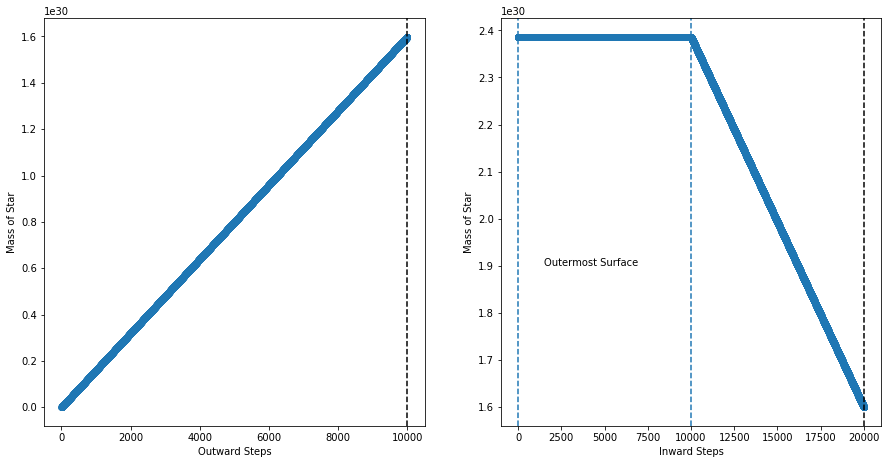

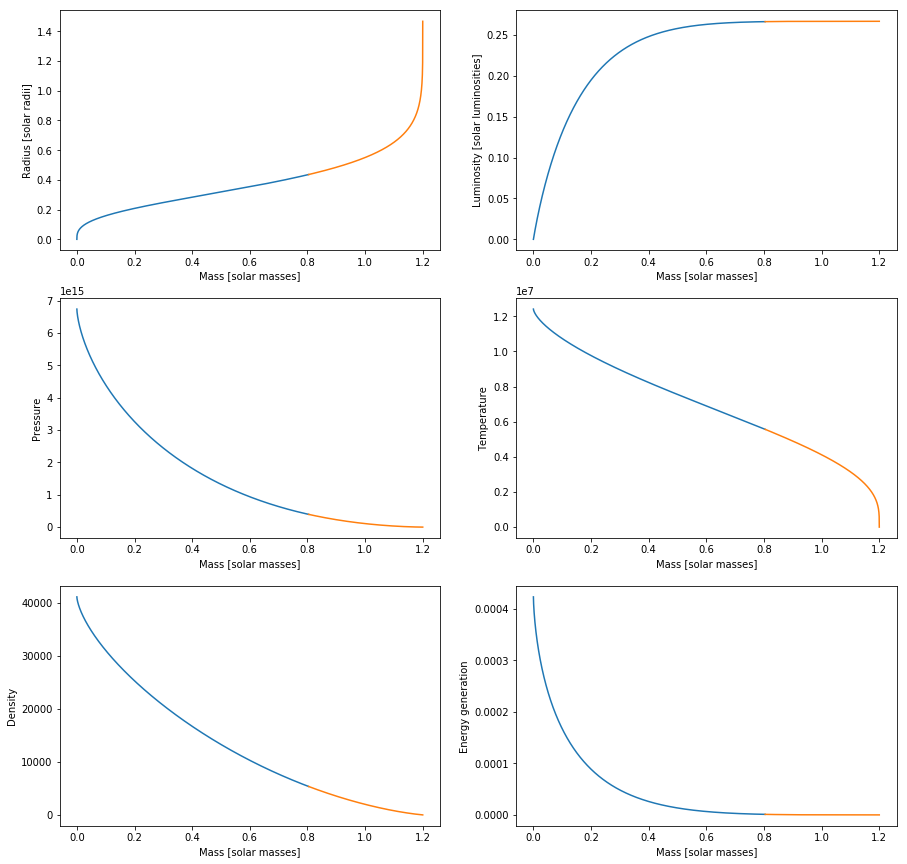

(array([ 1.02027899e+09,  1.02392767e+26,  6.74505390e+15,  1.24120673e+07]),
 array([-1.34287673e+03, -5.48339573e+19, -2.68924358e+09, -5.07349242e+02]),
 array([ 2.57485724e+04,  1.68522518e+20,  1.60001116e+11,  5.42386459e+02]))

In [7]:
# Print a nice heading for the text output

print("Iter   Radius          Luminosity      Core pressure   Core temperature")

# Start with an initial guess of the four boundary conditions

m0 = np.array([10**log_rs_i, 10**log_ls_i, 10**log_pc_i, 10**log_tc_i])
np.set_printoptions(formatter={'float_kind':"{: .8e}".format})
print("{0: 4d}".format(0), m0)

# Loop until mismatch values are smaller than the last-step changes in the same quantity

i=0
fraction = 10
while np.any(fraction > 1):
    m0, delta_rlpt, step_rlpt = improve(m0, False)
    fraction = np.abs(delta_rlpt/step_rlpt)
    
    i+=1
    print("{0:4d}".format(i), m0)

# Do one last iteration and plot the results
    
improve(m0, True)

This is great, but it can take quite a long time because there are lots of iterations and our code is far from optimised. We could do some work to improve the model code and make it faster, but this is beyond the scope of this activity. For now I'll simply present two alternative tolerances that may allow us to compute the model faster.

The first of these iterates until the fractional changes of all variables with respect to our initial values are below $0.5\%$.

Iter   Radius          Luminosity      Core pressure   Core temperature
   0 [ 7.07945784e+08  3.98107171e+26  1.25892541e+17  2.51188643e+07]
   1 [ 5.87076309e+08  2.39710916e+26  1.07385419e+17  2.48725242e+07]
   2 [ 5.26964363e+08  1.59741759e+26  9.32851246e+16  2.46184821e+07]
   3 [ 4.96831783e+08  1.22446436e+26  8.25159693e+16  2.43569943e+07]
   4 [ 4.81176741e+08  1.02459749e+26  7.41235707e+16  2.40898268e+07]
   5 [ 4.73229671e+08  9.03493155e+25  6.74421610e+16  2.38186892e+07]
   6 [ 4.69745274e+08  8.23043016e+25  6.20012404e+16  2.35451555e+07]
   7 [ 4.69023764e+08  7.65825277e+25  5.74679202e+16  2.32705800e+07]
   8 [ 4.70108619e+08  7.22966920e+25  5.36069017e+16  2.29960577e+07]
   9 [ 4.72429594e+08  6.89526715e+25  5.02515672e+16  2.27224288e+07]
  10 [ 4.75630049e+08  6.62549626e+25  4.72833294e+16  2.24503070e+07]
  11 [ 4.79478163e+08  6.40164192e+25  4.46171599e+16  2.21801152e+07]
  12 [ 4.83818950e+08  6.21128782e+25  4.21915284e+16  2.19121198e+07]
  13 

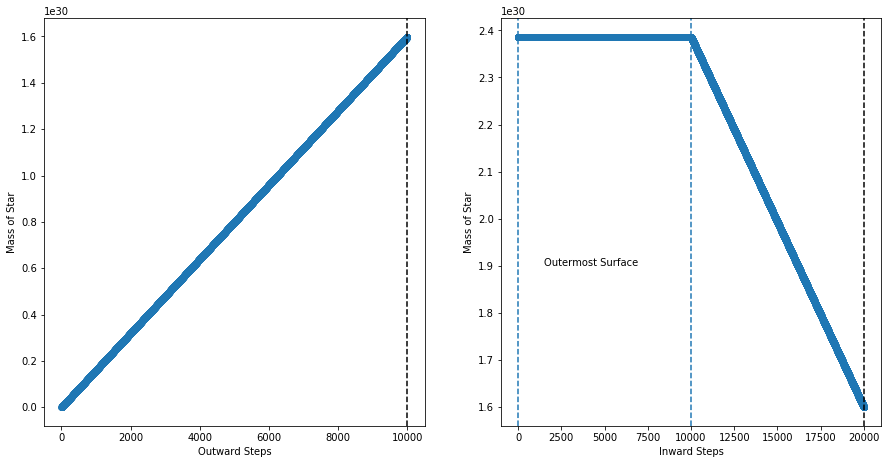

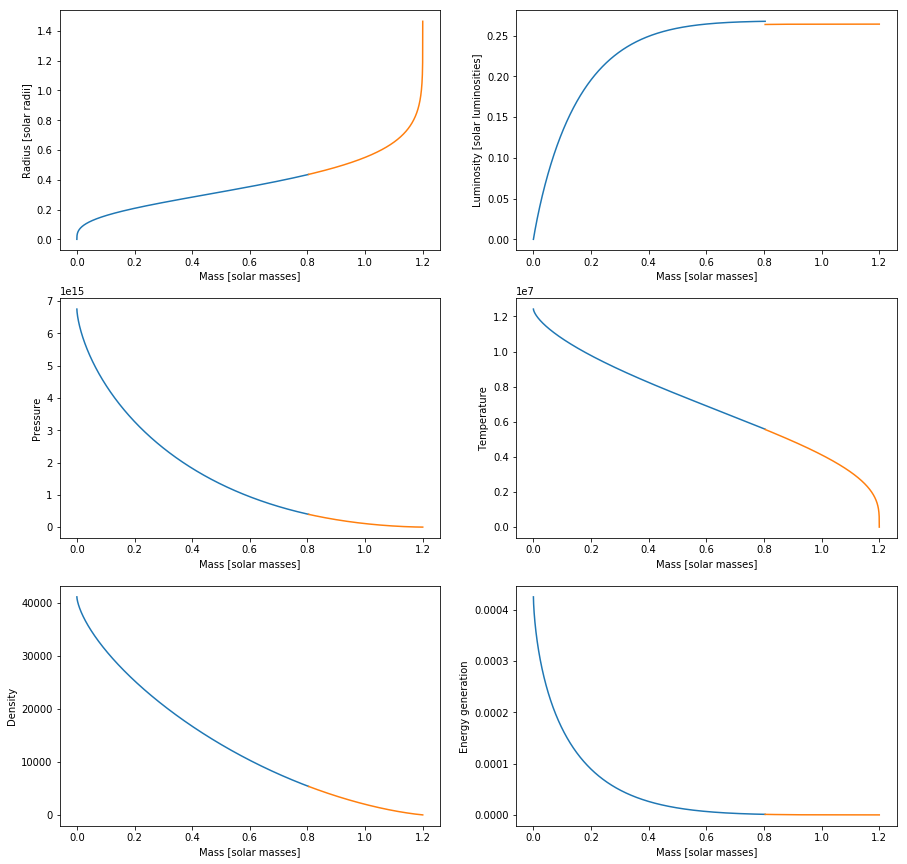

(array([ 1.01851371e+09,  1.01679787e+26,  6.75227340e+15,  1.24199093e+07]),
 array([-1.79908367e+05,  1.49016896e+24,  1.21220230e+12,  1.54436295e+04]),
 array([ 2.57109576e+04,  1.70767742e+20,  1.60334243e+11,  5.40323762e+02]))

In [8]:
# Print a nice heading for the text output

print("Iter   Radius          Luminosity      Core pressure   Core temperature")

# Start with an initial guess of the boundary conditions

m0 = np.array([10**log_rs_i, 10**log_ls_i, 10**log_pc_i, 10**log_tc_i])
np.set_printoptions(formatter={'float_kind':"{: .8e}".format})
print("{0: 4d}".format(0), m0)
init_m0 = np.copy(m0)

# Loop until fractional changes of all variables w.r.t. initial values are below 0.5% 

i = 0
fractional_change = np.array([100, 100, 100, 100])
while np.any(np.abs(fractional_change) > 0.5):
    m0, delta_rlpt, step_rlpt = improve(m0, False)
    fractional_change = np.array(delta_rlpt)*100/init_m0
    
    i+=1
    print("{0:4d}".format(i), m0)

# Do one last iteration and plot the results

improve(m0, True)

This was certainly faster - the number of iterations was reduced by a factor of almost 3 - but we can see there is still a slight mismatch in the luminosity integrations so the model isn't quite as good.

The final option is to loop for a fixed number of iterations. This gives us far greater control over how long the code takes to run, but the results may not be so great. This can also be a helpful approach if we want to see what is happening at a particular point in our process.

Iter   Radius          Luminosity      Core pressure   Core temperature
   0 [ 7.07945784e+08  3.98107171e+26  1.25892541e+17  2.51188643e+07]
   1 [ 5.87076309e+08  2.39710916e+26  1.07385419e+17  2.48725242e+07]
   2 [ 5.26964363e+08  1.59741759e+26  9.32851246e+16  2.46184821e+07]
   3 [ 4.96831783e+08  1.22446436e+26  8.25159693e+16  2.43569943e+07]
   4 [ 4.81176741e+08  1.02459749e+26  7.41235707e+16  2.40898268e+07]
   5 [ 4.73229671e+08  9.03493155e+25  6.74421610e+16  2.38186892e+07]
   6 [ 4.69745274e+08  8.23043016e+25  6.20012404e+16  2.35451555e+07]
   7 [ 4.69023764e+08  7.65825277e+25  5.74679202e+16  2.32705800e+07]
   8 [ 4.70108619e+08  7.22966920e+25  5.36069017e+16  2.29960577e+07]
   9 [ 4.72429594e+08  6.89526715e+25  5.02515672e+16  2.27224288e+07]
  10 [ 4.75630049e+08  6.62549626e+25  4.72833294e+16  2.24503070e+07]
  11 [ 4.79478163e+08  6.40164192e+25  4.46171599e+16  2.21801152e+07]
  12 [ 4.83818950e+08  6.21128782e+25  4.21915284e+16  2.19121198e+07]
  13 

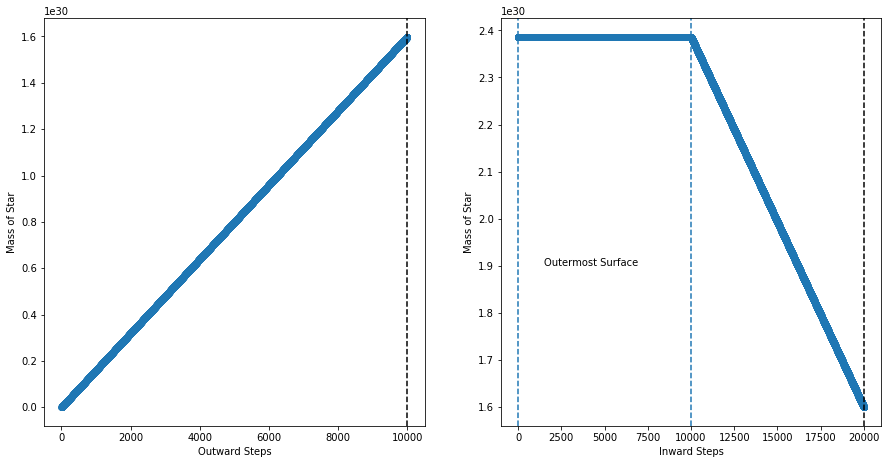

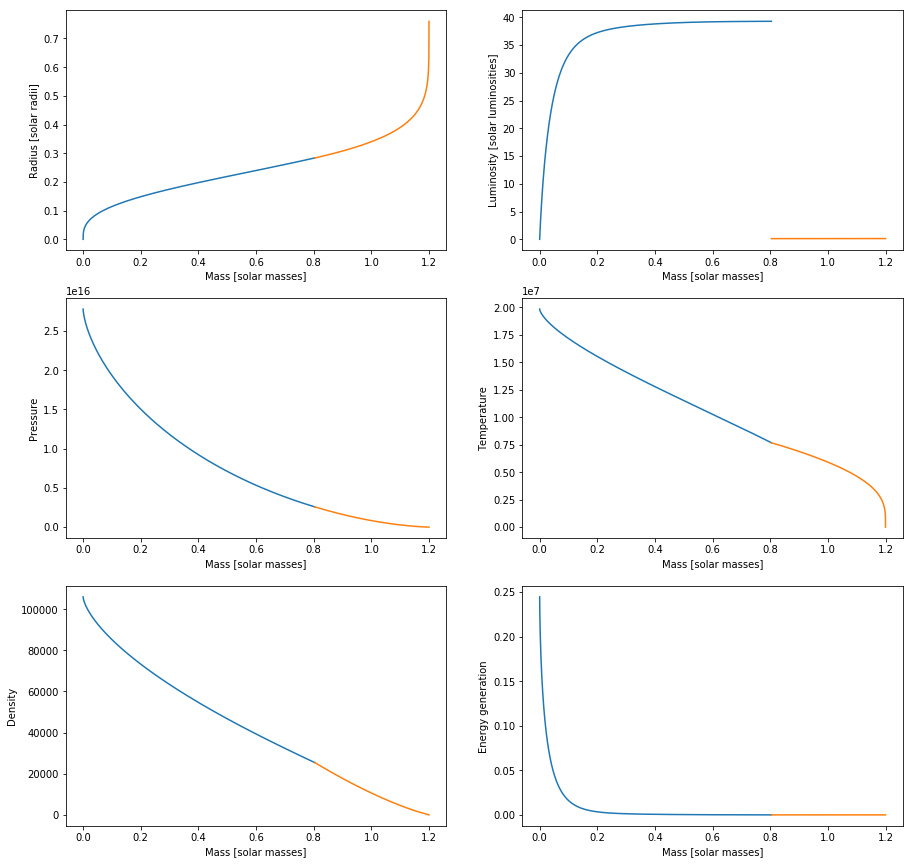

(array([ 5.34990091e+08,  5.14728029e+25,  2.63987823e+16,  1.95929857e+07]),
 array([ 1.41509847e+05,  1.50357484e+28, -2.92480661e+11,  5.14036056e+03]),
 array([ 1.28264297e+04,  4.48343713e+21,  8.91585588e+11,  1.06140930e+03]))

In [9]:
# Print a nice heading for the text output

print("Iter   Radius          Luminosity      Core pressure   Core temperature")

# Start with an initial guess of the boundary conditions

m0 = np.array([10**log_rs_i, 10**log_ls_i, 10**log_pc_i, 10**log_tc_i])
np.set_printoptions(formatter={'float_kind':"{: .8e}".format})
print("{0: 4d}".format(0), m0)

# Loop for a set number of iterations (currently 20)

for i in range(1,21):
    m0, delta_rlpt, step_rlpt = improve(m0, False)
    
    print("{0:4d}".format(i), m0)

# Do one last iteration and plot the results

improve(m0, True)

This did ok but clearly the luminosity remains flawed, and there is a bit of a bump in temperature and density. Where possible we should stick with the first method.